

## Diffusion-FS: Interpretable Diffusion and Progressive Distillation forTime Series Generation



In [ ]:
#!git clone https://github.com/LucaGeminiani00/Diffusion-Distillation-WL.git

In [ ]:
!git clone -b general-improvements https://github.com/LucaGeminiani00/Diffusion-Distillation-WL.git

Cloning into 'Diffusion-Distillation-WL'...
remote: Enumerating objects: 471, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 471 (delta 80), reused 41 (delta 41), pack-reused 360 (from 2)
Receiving objects: 100% (471/471), 21.54 MiB | 20.85 MiB/s, done.
Resolving deltas: 100% (214/214), done.


In [ ]:
%cd Diffusion-Distillation-WL

/content/Diffusion-Distillation-WL


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/test/colab_env/lib/python3.10/site-packages")

In [ ]:
!pip install PyWavelets pytorch_wavelets

## Necessary packages and functions call

In [ ]:
import os
import torch
import numpy as np

from Engine.trainer import full_distill
from Engine.trainer import Engine
from Utils.metric_utils import visualization
from Datasets.create_dataloader import create_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config, build_from_teacher
from Utils.fix_tensors import clean_keys, reshape_tensors
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

### Build dataset and settings

In [ ]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Configs/stocks.yaml'
        self.save_dir = './Save'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = create_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device) #This is only getting the PARAMS from Config
teacher = Engine(config=configs, args=args, model=model, dataloader=dl_info)

In [ ]:
model = teacher.model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}")

Total Parameters: 294390


### Training Original Model

In [ ]:
teacher.train()

In [ ]:
#LOAD Existing Milestones
class Args_Example:
    def __init__(self) -> None:
        self.gpu = 0
        self.config_path = './Configs/stocks.yaml'
        self.save_dir = './toy_exp'
        self.mode = 'infill'
        self.missing_ratio = 0.5
        self.milestone = 10
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = create_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
teacher = Engine(config=configs, args=args, model=model, dataloader=dl_info)

teacher.load(args.milestone)

### Full Distillation up to desired number of iterates

In [ ]:
students = full_distill(teacher, configs, dl_info, iters=7)

for student_name, student_instance in students.items():
    globals()[student_name] = student_instance

### Distillation Steps

In [ ]:
##New
teacher_keys = teacher.model.state_dict()
numsteps = teacher.model.num_timesteps
changeable = clean_keys(teacher_keys,numsteps)

reshape_tensors(teacher_keys, changeable)

config_0, model_0 = build_from_teacher(config=configs, device=device)

student0 = Engine(config=config_0, args=args, model=model_0, dataloader=dl_info)

student0.model.load_state_dict(teacher_keys)
student0.model.teacher = teacher

In [ ]:
student0.distill()


In [ ]:
teacher_keys = student0.model.state_dict()
reshape_tensors(teacher_keys, changeable)

config_1, model_1 = build_from_teacher(config=config_0, device=device)

student1 = Engine(config=config_1, args=args, model=model_1, dataloader=dl_info)

student1.model.load_state_dict(teacher_keys)
student1.model.teacher = student0

In [ ]:
student1.distill()

## Inference and Visualizations

### Sampling

In [ ]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
#ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_train.npy"))
ori_data = np.load(os.path.join(dataset.dir, f"stock_norm_truth_24_train.npy"))  # Uncomment the line if dataset other than Sine is used.

In [ ]:
fake_data = teacher.sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_train_fMRI.npy'), fake_data)

In [ ]:
fake_samples = []

#Setting the same seed allows to generate images on the same sample. If removed this will not be the case
for ind, student in enumerate(students):
    #Remove if not same seed
    torch.manual_seed(123)
    if torch.cuda.is_available():
      torch.cuda.manual_seed_all(123)
    #Remove if not same seed
    fake_data_s = students[student].sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
    if dataset.auto_norm:
        fake_data_s = unnormalize_to_zero_to_one(fake_data_s)

    locals()[f"fake_data_{ind}"] = fake_data_s
    fake_samples.append(fake_data_s)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock{ind}.npy'), fake_data_s)


In [ ]:
fake_data_0 = student0.sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data_0 = unnormalize_to_zero_to_one(fake_data_0)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock0.npy'), fake_data_0)

In [ ]:
fake_data_1 = student1.sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data_1 = unnormalize_to_zero_to_one(fake_data_1)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock1.npy'), fake_data_1)

### Visualization

We visualize the original and synthetic data distributions using PCA, tSNE and Density analysis.

/content/Diffusion-Distillation-WL/Utils/metric_utils.py:147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, color="red")
/content/Diffusion-Distillation-WL/Utils/metric_utils.py:148: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

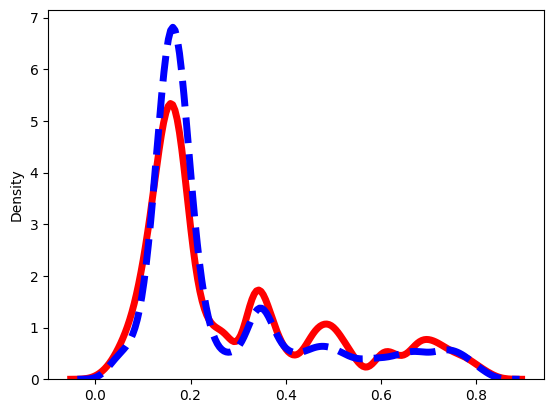

In [ ]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=ori_data.shape[0])

In [ ]:
#Single metric computation
from Utils.compute_metrics import compute_metrics
metrics_1 = compute_metrics(ori_data, fake_data)

Correlational score: 0.017200982335417715
Pearson's correlation: 0.021152279410736444


In [ ]:
from Utils.compute_metrics import train_metrics
predictors = train_metrics(ori_data,fake_data_0)

In [ ]:
fake_data_TS = np.load("/content/Diffusion-Distillation-WL/Datasets/fake_stock_TS.npy")

In [ ]:
#Train predictors on TimeGAN model: 

from Utils.compute_metrics import train_metrics
timeGAN = np.load("/content/Diffusion-Distillation-WL/Datasets/fmri_fake_data_15000.npy")
#timeGAN = np.concatenate([timeGAN, timeGAN[-2:, :, :]], axis=0)
oriGAN = np.load("/content/Diffusion-Distillation-WL/Datasets/fmri_ory_gan.npy")
predictors_GAN = train_metrics(oriGAN,timeGAN)

In [ ]:
timeVAE = np.load("/content/Diffusion-Distillation-WL/Datasets/timeVAE_fmri_prior_samples.npz")
timeVAE = timeVAE["data"]

In [ ]:
from Utils.compute_metrics import train_metrics
from Utils.compute_metrics import compute_metrics

In [ ]:
oriVAE = np.load("/content/Diffusion-Distillation-WL/Datasets/fmri.npz")
oriVAE = oriVAE["data"]
smaller_shape = timeVAE.shape
oriVAE = oriVAE[:smaller_shape[0], :smaller_shape[1], :smaller_shape[2]]
predictors_VAE = train_metrics(oriVAE,timeVAE)

In [ ]:
from Utils.compute_metrics import train_metrics
predictors_VAE = train_metrics(oriVAE,timeVAE)

In [ ]:
metrics_GAN = compute_metrics(oriGAN, timeGAN, predictors_GAN)

Correlational score: 32.112596352622646
Pearson's correlation: 0.000458223865152816
FID score: 6.54656005384628
Discriminative score: 0.4478957915831663
Predictive score: 0.14139282703399658


In [ ]:
metrics_WL = compute_metrics(ori_data, fake_data, predictors)

In [ ]:
metrics_TS = compute_metrics(ori_data, fake_data, predictors)

Correlational score: 29.825113739646646
Pearson's correlation: 0.00028372813743679205
FID score: 3.359974146449287
Discriminative score: 0.4620804108216433
Predictive score: 0.11733153462409973


In [ ]:
metrics_VAE = compute_metrics(oriVAE, timeVAE, predictors_VAE)

Correlational score: 23.843803661529844
Pearson's correlation: 0.00027417620800088485
FID score: 52.62676721064197
Discriminative score: 0.4999884001484781
Predictive score: 1.742447853088379


In [ ]:
from Utils.compute_metrics import train_metrics
predictors = train_metrics(ori_data,fake_data_0)

Training Discriminator:   0%|          | 0/2000 [00:00<?, ?it/s]

Training Predictor:   0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
#Iterative metric computation for all fake_samples
from Utils.compute_metrics import compute_metrics

metrics_dict = {}

for i, sample in enumerate(fake_samples):
    print("           ")
    print(f"Sample: {i}")
    metrics_dict[f"metrics_{i}"] = compute_metrics(ori_data, sample, predictors)

           
Sample: 0
Correlational score: 1.2992508885359215
Pearson's correlation: 0.03339708003301155
FID score: 0.15269730488408
Discriminative score: 0.12971299349057397
Predictive score: 0.2529066205024719
           
Sample: 1
Correlational score: 1.8641880890706723
Pearson's correlation: 0.03928146094530675
FID score: 0.31367543021135014
Discriminative score: 0.14638811395722373
Predictive score: 0.25311288237571716
           
Sample: 2
Correlational score: 2.193332467552577
Pearson's correlation: 0.03480537352432827
FID score: 0.3285133319840753
Discriminative score: 0.1459918420830163
Predictive score: 0.25291699171066284
           
Sample: 3
Correlational score: 3.0844514589700056
Pearson's correlation: 0.028769760640992164
FID score: 0.39818706448597996
Discriminative score: 0.15658022656183956
Predictive score: 0.25293976068496704
           
Sample: 4
Correlational score: 3.5652864341141592
Pearson's correlation: 0.023208717313740072
FID score: 0.5415587460543856
Discri

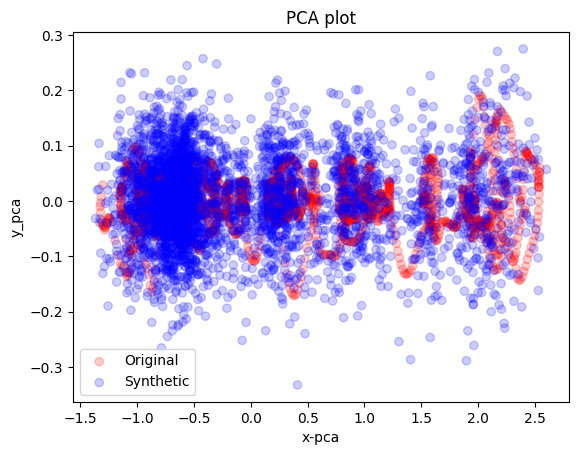

In [ ]:
ory = torch.from_numpy(ori_data).to(torch.float32).to(teacher.device)

b, c, n, device, feature_size, = *ory.shape, ory.device, teacher.model.feature_size
# Aggregate data: mean of all hours for each day for a specific feature
t = torch.full((b,), 50, device=device, dtype=torch.long)
fk = teacher.model.q_sample(ory, t=t, noise=None)
noised = fk.detach().cpu().numpy()

visualization(ori_data=ori_data, generated_data=noised, analysis='pca', compare=ori_data.shape[0])


In [ ]:
reconstructed_sample, imgs = teacher.exact_sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim],
                     forward_data=fk, specific=500)

In [ ]:
if dataset.auto_norm:
    reconstructed_sample = unnormalize_to_zero_to_one(reconstructed_sample)
    #np.save(os.path.join(args.save_dir, f'ddpm_reconstructed_train_sine.npy'), reconstructed_sample)

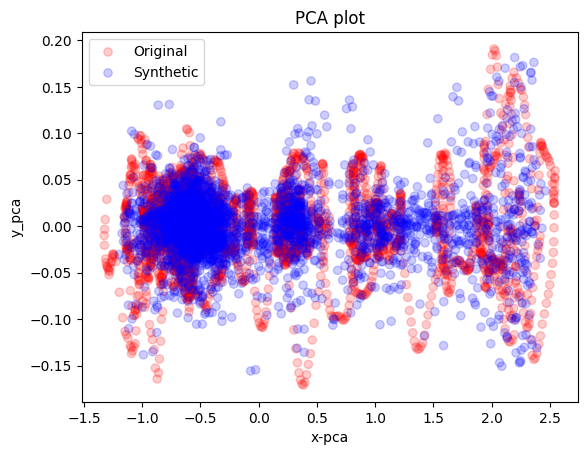

In [ ]:
visualization(ori_data=ori_data, generated_data=reconstructed_sample, analysis='pca', compare=ori_data.shape[0])